In [41]:
import OpenAttack as oa
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchtext.vocab as vocab
from IPython.core.display import display, HTML
from torchtext.data import get_tokenizer
from torchtext.datasets import SST2
from torchtext.vocab import build_vocab_from_iterator
%run models/Linear.ipynb
%run models/RNN.ipynb
%run models/SelfAttention.ipynb
import spacy
nlp = spacy.load("en_core_web_sm")

C:\Users\radug\AppData\Local\Temp\ipykernel_13136\2386527925.py:7: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter = SST2(split="train")
val_iter = SST2(split="dev")

tokenizer = get_tokenizer('spacy')


def yield_tokens_adv(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

D:\Python\Lib\site-packages\torchtext\data\utils.py:105: UserWarning:

Spacy model "en" could not be loaded, trying "en_core_web_sm" instead



In [43]:
vocabulary = build_vocab_from_iterator(yield_tokens_adv(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])
glove_vectors = vocab.GloVe(name='6B', dim=100)
vocabulary.vectors = glove_vectors.get_vecs_by_tokens(vocabulary.get_itos())

In [44]:

from OpenAttack.tags import TAG_English


class Tokenizer:
    """
    Tokenizer is the base class of all tokenizers.
    """
    TAGS = { TAG_English }
    def tokenize(self, x : str, pos_tagging : bool = True):
        """
        Args:
            x: A sentence.
            pos_tagging: Whether to return Pos Tagging results.

        Returns:
            A list of tokens if **pos_tagging** is `False`

            A list of (token, pos) tuples if **pos_tagging** is `True`

        POS tag must be one of the following tags: ``["noun", "verb", "adj", "adv", "other"]``

        """
        return self.do_tokenize(x, pos_tagging)

    def detokenize(self, x) -> str:
        """
        Args:
            x: The result of :py:meth:`.Tokenizer.tokenize`, can be a list of tokens or tokens with POS tags.
        Returns:
            A sentence.
        """
        if not isinstance(x, list):
            raise TypeError("`x` must be a list of tokens")
        if len(x) == 0:
            return ""
        x = [ it[0] if isinstance(it, tuple) else it for it in x ]
        return self.do_detokenize(x)


    def do_tokenize(self, x, pos_tagging):
        return tokenizer(x)

    def do_detokenize(self, x):
        return " ".join(x)


In [45]:
from OpenAttack.exceptions import WordNotInDictionaryException
from OpenAttack.attack_assist.goal import ClassifierGoal
from OpenAttack.attack_assist.filter_words import get_default_filter_words
from OpenAttack.text_process.tokenizer import get_default_tokenizer
from OpenAttack.utils import get_language, language_by_name, check_language
from OpenAttack.attack_assist.substitute.word import WordSubstitute, get_default_substitute
from OpenAttack import ClassificationAttacker, Classifier
from typing import List, Optional
import numpy as np
from OpenAttack.tags import TAG_English, Tag

class FDAttacker(ClassificationAttacker):
    @property
    def TAGS(self):
        return { self.__lang_tag, Tag("get_pred", "victim"), Tag("get_grad", "victim"), Tag("get_embedding", "victim") }

    def __init__(self,
                 substitute : Optional[WordSubstitute] = None,
                 tokenizer : Optional[Tokenizer] = None,
                 token_unk : str = "<UNK>",
                 max_iter : int = 100,
                 lang : Optional[str] = None,
                 filter_words : List[str] = None
                 ):
        """
        Crafting Adversarial Input Sequences For Recurrent Neural Networks. Nicolas Papernot, Patrick McDaniel, Ananthram Swami, Richard Harang. MILCOM 2016.
        `[pdf] <https://arxiv.org/pdf/1604.08275.pdf>`__

        Args:
            substitute: A substitute that will be used during the attack procedure. Must be an instance of :py:class:`.WordSubstitute`
            tokenizer: A tokenizer that will be used during the attack procedure. Must be an instance of :py:class:`.Tokenizer`
            token_unk: The token id or the token name for out-of-vocabulary words in victim model. **Default:** ``"<UNK>"``
            max_iter: Maximum number of iterations in attack procedure.
            lang: The language used in attacker. If is `None` then `attacker` will intelligently select the language based on other parameters.
            filter_words: A list of words that will be preserved in the attack procesudre.

        :Classifier Capacity:
            * get_pred
            * get_grad
            * get_embedding

        """

        if substitute is not None and tokenizer is not None:
            self.__lang_tag = get_language([substitute, tokenizer])
        if substitute is not None:
            self.__lang_tag = get_language([substitute])
        elif tokenizer is not None:
            self.__lang_tag = get_language([tokenizer])
        else:
            if lang is None:
                self.__lang_tag = TAG_English
            else:
                self.__lang_tag = language_by_name(lang)
                if self.__lang_tag is None:
                    raise ValueError("Unknown language `%s`" % lang)

        if substitute is None:
            substitute = get_default_substitute(self.__lang_tag)

        self.substitute = substitute

        if tokenizer is None:
            tokenizer = get_default_tokenizer(self.__lang_tag)
        self.tokenizer = tokenizer

        if filter_words is None:
            filter_words = get_default_filter_words(self.__lang_tag)
        self.filter_words = set(filter_words)

        check_language([self.tokenizer, self.substitute], self.__lang_tag)

        self.token_unk = token_unk
        self.max_iter = max_iter

    def attack(self, victim: Classifier, x_orig, goal: ClassifierGoal):
        x_orig = x_orig.lower()

        sent = self.tokenizer.tokenize(x_orig, pos_tagging=False)

        victim_embedding = victim.get_embedding()

        for i in range(self.max_iter):
            curr_sent = self.tokenizer.detokenize(sent)
            pred = victim.get_pred([ curr_sent ])[0]
            if goal.check(curr_sent, pred):
                return curr_sent
            elif i != 0:
                sent[idx] = temp

            iter_cnt = 0
            while True:
                idx = np.random.choice(len(sent))
                temp = sent[idx]
                iter_cnt += 1
                if iter_cnt > 5 * len(sent):    # Failed to find a substitute word
                    return None
                if sent[idx] in self.filter_words:
                    continue
                try:
                    reps = list(map(lambda x:x[0], self.substitute(sent[idx], None)))
                except WordNotInDictionaryException:
                    continue
                reps = list(filter(lambda x: x in victim_embedding.word2id, reps))
                if len(reps) > 0:
                    break

            prob, grad = victim.get_grad([sent], [goal.target])
            grad = grad[0]
            prob = prob[0]
            if grad.shape[0] != len(sent) or grad.shape[1] != victim_embedding.embedding.shape[1]:
                raise RuntimeError("Sent %d != Gradient %d" % (len(sent), grad.shape[0]))
            s1 = np.sign(grad[idx])

            mn = None
            mnwd = None

            for word in reps:
                # print(reps)
                s0 = np.sign(victim_embedding.transform(word, self.token_unk) - victim_embedding.transform(sent[idx], self.token_unk))
                v = np.abs(s0 - s1).sum()
                if goal.targeted:
                    v = -v

                if (mn is None) or v < mn:
                    mn = v
                    mnwd = word

            if mnwd is None:
                return None
            sent[idx] = mnwd

        return None

In [46]:
from torch import nn
import datasets
from torch.func import grad

def dataset_mapping(x):
    return {
        "x": x["sentence"],
        "y": 1 if x["label"] > 0.5 else 0,
    }


# configure access interface of the customized victim model by extending OpenAttack.Classifier.
class MyClassifier(oa.Classifier):
    def __init__(self, model, choice=None):
        self.model = model
        self.choice = choice

    def get_pred(self, input_):
        return self.get_prob(input_).argmax(axis=1)

    # access to the classification probability scores with respect input sentences
    def get_prob(self, input_):
        ret = []
        for sent in input_:
            seq = []
            for word in tokenizer(sent):
                seq.append(vocabulary[word])
            v = torch.tensor(seq).view(1, -1)
            v = v.to(device)
            if self.choice==0:
                res = self.model.forward(v)
            else:
                res, _  = self.model.forward(v)
            res = F.softmax(res, dim=1)
            res = {"pos": res[0, 0].cpu().detach().numpy(), "neg": res[0, 1].cpu().detach().numpy()}
            # we use 𝑠𝑜𝑐𝑟𝑒𝑝𝑜𝑠 / (𝑠𝑐𝑜𝑟𝑒𝑛𝑒𝑔 + 𝑠𝑐𝑜𝑟𝑒_𝑝𝑜𝑠) to represent the probability of positive sentiment
            # Adding 10^−6 is a trick to avoid dividing by zero.
            prob = (res["pos"] + 1e-6) / (res["neg"] + res["pos"] + 2e-6)

            ret.append(np.array([1 - prob, prob]))

        # The get_prob method finally returns a np.ndarray of shape (len(input_), 2). See Classifier for detail.
        return np.array(ret)
    def get_embedding(self):
        return oa.attack_assist.word_embedding.WordEmbedding(vocabulary, vocabulary.vectors)
    def get_grad(self, sent, target):
        seq = []
        sent = sent[0]
        target = target[0]
        for word in sent:
            seq.append(vocabulary[word])
        v = torch.tensor(seq).view(1, -1)
        v = v.to(device)
        x = xe = None
        if self.choice == 0:
            xe = self.model.embedding(v)
            xe.requires_grad = True
            x = self.model.fc(xe.sum(dim=1))
            x = self.model.relu(x)
            x = self.model.fc2(x)
        elif self.choice == 1:
            xe = self.model.embedding(v)
            xe.requires_grad = True
            x, final_hidden_state = self.model.rnn(xe)
            final_hidden_state = final_hidden_state.mean(dim=0)
            x, weights = self.model.compute_attention(final_hidden_state)
            x = self.model.out(x)
        elif self.choice == 2:

            xe = self.model.embedding(v)
            xe.requires_grad = True

            x = self.model.posEncode(xe)

            x, weights = self.model.attention(x)
            x = torch.mean(x, dim=1)
            x = self.model.fc1(x)
            x = self.model.relu(x)
            x = self.model.fc2(x)
        loss = nn.CrossEntropyLoss()(x, F.one_hot(torch.tensor(target).long().to(device), num_classes=2).float().unsqueeze(dim=0))

        self.model.zero_grad()

        loss.backward(retain_graph=True)
        res = F.softmax(x, dim=1)
        d_res = {"pos": res[0, 0].cpu().detach().numpy(), "neg": res[0, 1].cpu().detach().numpy()}
        # we use 𝑠𝑜𝑐𝑟𝑒𝑝𝑜𝑠 / (𝑠𝑐𝑜𝑟𝑒𝑛𝑒𝑔 + 𝑠𝑐𝑜𝑟𝑒_𝑝𝑜𝑠) to represent the probability of positive sentiment
        # Adding 10^−6 is a trick to avoid dividing by zero.
        prob = (d_res["pos"] + 1e-6) / (d_res["neg"] + d_res["pos"] + 2e-6)

        grad = xe.grad.squeeze(dim=0)
        return [prob], [grad.cpu().detach().numpy()]

dataset = datasets.load_dataset("sst2", split="validation[:50]").map(function=dataset_mapping)
attacker = FDAttacker(tokenizer=Tokenizer())

Found cached dataset sst2 (C:/Users/radug/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached processed dataset at C:\Users\radug\.cache\huggingface\datasets\sst2\default\2.0.0\9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5\cache-7b537c69981622b9.arrow


### Metrics

In [47]:
class PerturbationPosition(oa.AttackMetric):
    NAME = "PerturbationPosition"

    def __init__(self):
        self.counts = []

    def after_attack(self, sample, adversarial_sample):
        if adversarial_sample is None:
            return -1
        sample = tokenizer(sample["sentence"])
        adversarial_sample = tokenizer(adversarial_sample)
        for i, (word, word_adv) in enumerate(zip(sample, adversarial_sample)):
            if word != word_adv:
                self.counts.append(i / len(sample))


class StoreAdversarialCandidates(oa.AttackMetric):
    NAME = "AdversarialCandidates"

    def __init__(self, model):
        self.embeddings = []
        self.model = model

    def after_attack(self, sample, adversarial_sample):
        # print(sample, adversarial_sample)
        if adversarial_sample is None:
            return
        adversarial_sample = tokenizer(adversarial_sample)
        seq = []
        for word in adversarial_sample:
            seq.append(vocabulary[word])
        seq = torch.tensor(seq).to(device)
        emb = self.model.embedding(seq)
        self.embeddings.append(emb)
        return -1

In [48]:
class PerturbationAttention(oa.AttackMetric):
    NAME = "PerturbationAttention"

    def __init__(self, model):
        self.model = model
        self.sample = {'words': [], 'attention': []}
        self.adversarial_sample = {'words': [], 'attention': []}
        self.word_counts = []

    def after_attack(self, sample, adversarial_sample):
        if adversarial_sample is None:
            return -1
        seq = []
        seq_adv = []
        sample = tokenizer(sample["sentence"])
        adversarial_sample = tokenizer(adversarial_sample)
        self.sample['words'].append(sample)
        #print(sample)
        self.adversarial_sample['words'].append(adversarial_sample)
        cnt = 0
        for i, (word1, word2) in enumerate(zip(sample, adversarial_sample)):
            seq.append(vocabulary[word1])
            seq_adv.append(vocabulary[word2])
            cnt += 1
        self.word_counts.append(cnt)
        seq = torch.tensor(seq).view(1, -1).to(device)
        seq_adv = torch.tensor(seq_adv).view(1, -1).to(device)
        self.sample['attention'].append(self.model.forward(seq)[1])
        self.adversarial_sample['attention'].append(self.model.forward(seq_adv)[1])

In [49]:
def concatenateMaps(map_tensor, adversial_map_tensor, num_sentences, rnn_flag=False):
    attention_map = []
    adv_attention_map = []
    for i in range(num_sentences):
        if rnn_flag:
            att = map_tensor[i].squeeze(0)
            adv_att = adversial_map_tensor[i].squeeze(0)
        else:
            att = torch.mean(map_tensor[i].squeeze(0), dim=1)
            adv_att = torch.mean(adversial_map_tensor[i].squeeze(0), dim=1)

        attention_map.append(att.cpu().detach().numpy())
        adv_attention_map.append(adv_att.cpu().detach().numpy())
    return attention_map, adv_attention_map


#generate for all sentences in the batch
def generateHeatedText(words, attention_map):
    text = []
    for i in range(len(words)):
        word = '<span style="background-color:rgba(255, 99, 71,' + str(attention_map[i]) + ')">' + words[i] + '</span>'
        text.append(word)
    text = ' '.join(text)

    display(HTML(text))

### Fully Connected Attack

In [50]:
net = FC(vocabulary)
net.load_state_dict(torch.load('models/fc.pt'))
net.to(device)
# net.eval()
pp = PerturbationPosition()

sad_fc = StoreAdversarialCandidates(net)
victim = MyClassifier(net, choice=0)  # prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp, sad_fc
])
# launch attacks and print attack results
attack_fc = attack_eval.eval(dataset, visualize=True, progress_bar=False)
attack_fc

Sample: 1 =====================================================================
Label: 0 (87.38%) --> Failed!               |                                   
                                            | Running Time:            0.15552  
                                            | Query Exceeded:          no       
it ' s a charming and often affecting       | Victim Model Queries:    201      
journey .                                   | PerturbationPosition:    -1       
                                            | Succeed:                 no       
                                            |                                   
Sample: 2 =====================================================================
Label: 1 (99.80%) --> Failed!               |                                   
                                            | Running Time:            0.12949  
                                            | Query Exceeded:          no       
unflinchingly bleak and desper

{'Total Attacked Instances': 50,
 'Successful Instances': 8,
 'Attack Success Rate': 0.16,
 'Avg. Running Time': 0.11928141117095947,
 'Total Query Exceeded': 0.0,
 'Avg. Victim Model Queries': 170.14,
 'Avg. PerturbationPosition': -1.0,
 'Avg. AdversarialCandidates': -1.0}

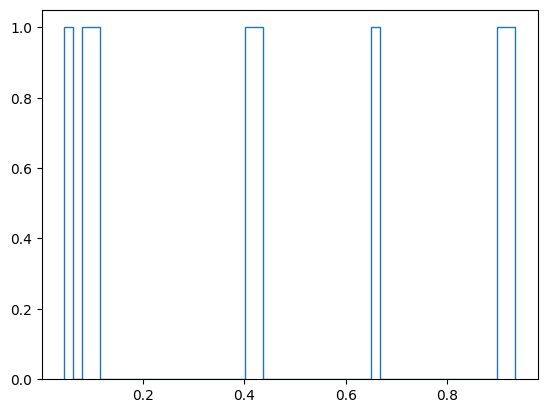

In [51]:
counts = np.array(pp.counts)
counts = counts[counts >= 0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

### RNN Attack

In [52]:
net = RNN(vocabulary)
net.load_state_dict(torch.load('models/rnn.pt'))
net.to(device)
# net.eval()
pp = PerturbationPosition()
pa = PerturbationAttention(net)
sad_rnn = StoreAdversarialCandidates(net)
victim = MyClassifier(net, choice=1)
# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp, pa, sad_rnn
])
# launch attacks and print attack results
attack_rnn = attack_eval.eval(dataset, visualize=True, progress_bar=False)
attack_rnn

Sample: 1 =====================================================================
Label: 0 (68.18%) --> 1 (70.15%)            |                                   
                                            | Running Time:            0.0030208
it ' s a charming and often affecting       | Query Exceeded:          no       
it ' s a magical  and often affecting       | Victim Model Queries:    9        
                                            | AdversarialCandidates:   -1       
journey .                                   | Succeed:                 yes      
journey .                                   |                                   
                                            |                                   
Sample: 2 =====================================================================
Label: 1 (86.20%) --> Failed!               |                                   
                                            | Running Time:            0.1507   
                              

{'Total Attacked Instances': 50,
 'Successful Instances': 11,
 'Attack Success Rate': 0.22,
 'Avg. Running Time': 0.13156827926635742,
 'Total Query Exceeded': 0.0,
 'Avg. Victim Model Queries': 159.84,
 'Avg. AdversarialCandidates': -1.0,
 'Avg. PerturbationPosition': -1.0,
 'Avg. PerturbationAttention': -1.0}

In [53]:
allWords = sum(pa.sample['words'], [])
allWords_adv = sum(pa.adversarial_sample['words'], [])
attention_map_rnn, adv_attention_map_rnn = concatenateMaps(pa.sample['attention'], pa.adversarial_sample['attention'],
                                                           len(pa.sample['words']), rnn_flag=True)

idx = 1
generateHeatedText(pa.sample['words'][idx], attention_map_rnn[idx])

generateHeatedText(pa.adversarial_sample['words'][idx], adv_attention_map_rnn[idx])

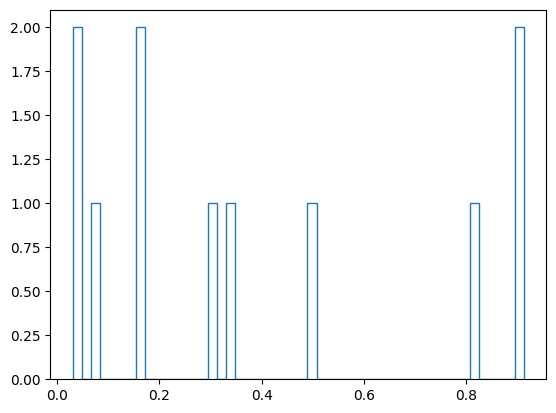

In [54]:
counts = np.array(pp.counts)
counts = counts[counts >= 0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

### Self-Attention Attack


In [55]:
net = AttentionModel(vocabulary)
net.load_state_dict(torch.load('models/attention.pt'))
net.to(device)
net.eval()
pp = PerturbationPosition()
pa = PerturbationAttention(net)
sad_sa = StoreAdversarialCandidates(net)
victim = MyClassifier(net, choice=2)
# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp, pa, sad_sa
])
# launch attacks and print attack results
attack_att = attack_eval.eval(dataset, visualize=True, progress_bar=False)
attack_att

Sample: 1 =====================================================================
Label: 1 (77.60%) --> Failed!               |                                   
                                            | Running Time:            0.22034  
                                            | Query Exceeded:          no       
it ' s a charming and often affecting       | Victim Model Queries:    201      
journey .                                   | PerturbationPosition:    -1       
                                            | PerturbationAttention:   -1       
                                            | Succeed:                 no       
                                            |                                   
Sample: 2 =====================================================================
Label: 1 (100.00%) --> Failed!              |                                   
                                            | Running Time:            0.14337  
                              

{'Total Attacked Instances': 50,
 'Successful Instances': 10,
 'Attack Success Rate': 0.2,
 'Avg. Running Time': 0.13710090160369873,
 'Total Query Exceeded': 0.0,
 'Avg. Victim Model Queries': 162.4,
 'Avg. PerturbationPosition': -1.0,
 'Avg. PerturbationAttention': -1.0,
 'Avg. AdversarialCandidates': -1.0}

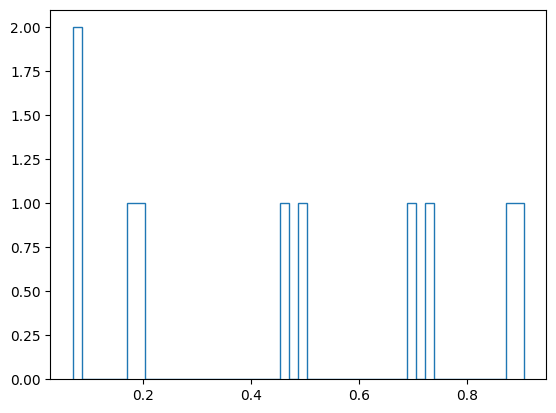

In [56]:
counts = np.array(pp.counts)
counts = counts[counts >= 0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

In [57]:
allWords = sum(pa.sample['words'], [])
allWords_adv = sum(pa.adversarial_sample['words'], [])
attention_map, adv_attention_map = concatenateMaps(pa.sample['attention'], pa.adversarial_sample['attention'],
                                                   len(pa.sample['words']))

In [58]:
idx = 2

generateHeatedText(pa.sample['words'][idx], attention_map[idx])
generateHeatedText(pa.adversarial_sample['words'][idx], adv_attention_map[idx])

In [59]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go


def display_pca_scatterplot_3D(topn=-1):
    fc_embs = torch.cat(sad_fc.embeddings, dim=0).cpu().detach().numpy()
    rnn_embs = torch.cat(sad_rnn.embeddings, dim=0).cpu().detach().numpy()
    sa_embs = torch.cat(sad_sa.embeddings, dim=0).cpu().detach().numpy()
    three_dim_fc = PCA(random_state=0).fit_transform(fc_embs)[:, :3]
    three_dim_rnn = PCA(random_state=0).fit_transform(rnn_embs)[:, :3]
    three_dim_sa = PCA(random_state=0).fit_transform(sa_embs)[:, :3]
    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:2]
    data = []
    trace_input_fc = go.Scatter3d(
        x=three_dim_fc[:topn, 0],
        y=three_dim_fc[:topn, 1],
        z=three_dim_fc[:topn, 2], mode='markers'
    )
    trace_input_rnn = go.Scatter3d(
        x=three_dim_rnn[:topn, 0],
        y=three_dim_rnn[:topn, 1],
        z=three_dim_rnn[:topn, 2], mode='markers'
    )
    trace_input_sa = go.Scatter3d(
        x=three_dim_sa[:topn, 0],
        y=three_dim_sa[:topn, 1],
        z=three_dim_sa[:topn, 2], mode='markers'
    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)

    data.append(trace_input_fc)
    data.append(trace_input_rnn)
    data.append(trace_input_sa)

    # Configure the layout

    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
            x=1,
            y=0.5,
            font=dict(
                family="Courier New",
                size=25,
                color="black"
            )),
        font=dict(
            family=" Courier New ",
            size=15),
        autosize=False,
        width=1000,
        height=1000
    )

    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.show()


display_pca_scatterplot_3D(topn=1000)